<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#Embeddings-CTNet" data-toc-modified-id="Embeddings-CTNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embeddings CTNet</a></span></li><li><span><a href="#Modificar-modelo-para-sacar-cosas" data-toc-modified-id="Modificar-modelo-para-sacar-cosas-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modificar modelo para sacar cosas</a></span></li><li><span><a href="#One-graph-embedding" data-toc-modified-id="One-graph-embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One graph embedding</a></span></li><li><span><a href="#All-graphs-embedding" data-toc-modified-id="All-graphs-embedding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>All graphs embedding</a></span></li><li><span><a href="#DIGL" data-toc-modified-id="DIGL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DIGL</a></span></li></ul></div>

Para CTNet, MinCutNet, GapNet and DIGL (4 figuras de cada task): 
- [ ] Embeddings de un grafo solo *conv2* -> dispersión
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [X] Embeddings de to los grafos (después del readout) pa plotearlo todos juntos y que se vea la separación entre clases
    * Train vs test
- [ ] Grafo con ejes con peso CT matrix en CTNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [ ] Grafo con ejes adjacency modificada en GapNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [X] Datos sobre grafos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from nets import CTNet, GAPNet

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from transform_features import FeatureDegree
from torch_geometric.datasets import TUDataset

from sklearn.model_selection import train_test_split


import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
@torch.no_grad()
def test(modelo, loader, device):
    modelo.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = modelo(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


## Import dataset

In [5]:
dataset = TUDataset(root='data_colab/TUDataset',name="REDDIT-BINARY", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 16
num_of_centers = 420

"""dataset = TUDataset(root='data_colab/TUDataset',name="MUTAG")
BATCH_SIZE = 32
num_of_centers = 17"""

'dataset = TUDataset(root=\'data_colab/TUDataset\',name="MUTAG")\nBATCH_SIZE = 32\nnum_of_centers = 17'

In [6]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}, {dataset.num_node_features}, {dataset.num_node_attributes}')
print(f'Number of classes: {dataset.num_classes}')

print()
datum = dataset[0]  # Get the first graph object.
print(datum)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {datum.num_nodes}')
print(f'Number of edges: {datum.num_edges}')
print(f'Average node degree: {datum.num_edges / datum.num_nodes:.2f}')
print(f'Has isolated nodes: {datum.has_isolated_nodes()}')
print(f'Has self-loops: {datum.has_self_loops()}')
print(f'Is undirected: {datum.is_undirected()}')


print(dataset)

Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1, 1, 1
Number of classes: 2

Data(edge_index=[2, 480], y=[1], x=[218, 1], num_nodes=218)
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Has isolated nodes: False
Has self-loops: False
Is undirected: True
REDDIT-BINARY(2000)


In [7]:
train_indices, test_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y,
                                random_state=12345, shuffle=True)

train_indices.extend(test_indices)
new_order = train_indices
dataset = dataset[new_order]
loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

## Embeddings CTNet

**Probar modelo guardaddo**

In [10]:
if dataset.name=='REDDIT-BINARY':
    modelito = "models/REDDIT-BINARY_CTNet_iter0.pth"
elif dataset.name=='MUTAG':
    modelito = "models/MUTAG_CTNet_iter0.pth"
else:
    raise Exception('No model for that dataset')

In [11]:
#Epoch: 059, Train Loss: 165.455, Train Acc: 0.711, Test Loss: 150.841, Test Acc: 0.750
model =  CTNet(dataset.num_features, dataset.num_classes, k_centers=num_of_centers).to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

CTNet(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=420, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

In [12]:
loss, acc = test(model, loader, device)

In [13]:
loss, acc

(tensor(84.7053, device='cuda:0'), 0.711)

## Modificar modelo para sacar cosas

In [14]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj
from CT_layer import dense_CT_rewiring
from MinCut_Layer import dense_mincut_pool

**Modelo y Test modificado que coja los embeddings**

In [15]:
class CTNet_embedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32):
        super(CTNet_embedding, self).__init__()
    
        self.lin1 = Linear(in_channels, hidden_channels)
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        #self.CT = CTLayer()
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2)
        #self.MinCut = MinCutLayer()
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels) # MLPs towards out 
        self.lin3 = Linear(hidden_channels, out_channels)
        
        self.readout = torch.zeros(0)#Creamos la variable que recoge nuestros embedings

    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch) # adj torch.Size(B, N, N])
        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40:
        x, mask = to_dense_batch(x, batch) # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)

        if torch.isnan(adj).any():
            print("adj nan")
        if torch.isnan(x).any():
            print("x nan")
        
        # CT REWIRING
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])

        # MLP of k=16 outputs s
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        
        # MINCUT_POOL
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) # x torch.Size([20, 32])
        
        #Queremos esta x, por lo que nos la guardamos
        self.readout = x.clone()
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) # x torch.Size([20, 32])
        x = self.lin3(x) #x torch.Size([20, 2])
        #print(x.shape)
        
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss


In [16]:
model =  CTNet_embedding(dataset.num_features, dataset.num_classes, k_centers=num_of_centers).to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

CTNet_embedding(
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (pool1): Linear(in_features=32, out_features=420, bias=True)
  (conv1): DenseGraphConv(32, 32)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (conv2): DenseGraphConv(32, 32)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

In [17]:
@torch.no_grad()
def test_embedd(modelo, loader, device):
    test_predictions = []
    test_labels = []
    modelo.eval()
    correct = 0
    for i,data in enumerate(loader):
        data = data.to(device)
        pred, mc_loss, o_loss = modelo(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()
        test_predictions.extend(pred.max(dim=1)[1].tolist())
        test_labels.extend(data.y.detach().cpu().numpy())
        
        if i == 0:
            test_embeddings = modelo.readout
        else:
            test_embeddings = torch.cat((test_embeddings,modelo.readout.detach()), 0)
        
        #print(modelo.emb.shape)
    return loss.detach().cpu(), correct / len(loader.dataset), test_embeddings, test_labels, test_predictions

**Evaluar modelo para chequear comportamiento**

In [18]:
import numpy as np
loss, acc, test_embeddings, test_labels, test_predictions = test_embedd(model, loader, device)
test_embeddings = test_embeddings.detach().cpu()
print('Embedding shape:',test_embeddings.shape, test_embeddings.device)
print('Dataset size:',len(test_predictions))

Embedding shape: torch.Size([2000, 32]) cpu
Dataset size: 2000


In [19]:
print('Embedding shape:',test_embeddings.shape, test_embeddings.device)
print('Dataset size:',len(test_predictions))

Embedding shape: torch.Size([2000, 32]) cpu
Dataset size: 2000


In [20]:
loss, acc

(tensor(84.7053), 0.711)

**Plotear embeddings con sus correspondientes etiquetas y predicciones en sus correspondiente partición.**

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_indices, test_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y,
                                random_state=12345, shuffle=True)
#train_dataset = torch.utils.data.Subset(dataset, train_indices)
#test_dataset = torch.utils.data.Subset(dataset, test_indices)

e = np.array(test_embeddings)
p = np.array(test_predictions)
l = np.array(test_labels)
print('Acc:',(np.sum(p == l)/len(p))*100)

e_train = e[train_indices]
e_test  = e[test_indices]
lab_train = l[train_indices]
lab_test  = l[test_indices]
pred_train = p[train_indices]
pred_test  = p[test_indices]

Acc: 71.1


In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm

def print_embeddings(train_embedd, test_embedd, train_labels, test_labels, train_pred, test_pred, num_categories):
    
    train_embedd = np.array(train_embedd)
    train_labels = np.array(train_labels)
    test_embedd = np.array(test_embedd)
    test_labels = np.array(test_labels)

    tsne = TSNE(n_components=2, verbose=0, perplexity=80, learning_rate=800)
    tsne_results = tsne.fit_transform(np.vstack([train_embedd,test_embedd]))
    
    train_embedd_2dim = tsne_results[:len(train_embedd)]
    test_embedd_2dim = tsne_results[len(train_embedd):]

    cmap = cm.get_cmap('Set2')
    fig, ax = plt.subplots(1, 2, figsize=(17,8))

    for lab in range(num_categories):
        train_indices_lab = train_labels == lab
        test_indices_lab = test_labels == lab
        
        ax[0].scatter(train_embedd_2dim[train_indices_lab,0], train_embedd_2dim[train_indices_lab,1],
                   c=np.array(cmap(lab)).reshape(1,4), label = f"{lab}_train" ,alpha=0.5, marker ='o')
        #ax[0].scatter(test_embedd_2dim[test_indices_lab,0], test_embedd_2dim[test_indices_lab,1],
        #           c=np.array(cmap(lab)).reshape(1,4), label = f"{lab}_test" ,alpha=0.5, marker ='x')
        ax[0].set_title('Real Label')
        
    for lab in range(num_categories):
        train_indices_pred = train_pred == lab
        test_indices_pred = test_pred == lab
        
        acc_test = (np.sum(test_pred == test_labels)/len(test_labels))*100
        acc_train = (np.sum(train_pred == train_labels)/len(train_pred))*100
        
        #ax[1].scatter(train_embedd_2dim[train_indices_pred,0], train_embedd_2dim[train_indices_pred,1],
        #           c=np.array(cmap(lab)).reshape(1,4), label = f"{lab}_train" ,alpha=0.5, marker ='o')
        ax[1].scatter(test_embedd_2dim[test_indices_pred,0], test_embedd_2dim[test_indices_pred,1],
                   c=np.array(cmap(lab)).reshape(1,4), label = f"{lab}_test" ,alpha=0.5, marker ='x')
        ax[1].set_title(f'Predicted\n$Acc_{{train}}={acc_train:.1f}$ - $Acc_{{test}}={acc_test:.1f}$')

        ax[1].legend(fontsize='large', markerscale=2)
    plt.show()

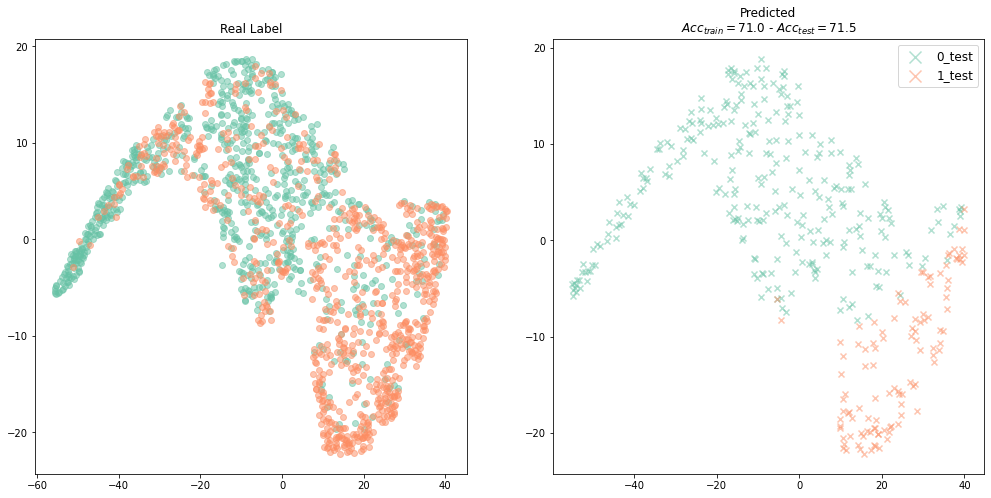

In [24]:
print_embeddings(e_train, e_test, lab_train, lab_test, pred_train, pred_test, len(set(l)))

In [25]:
STOP

NameError: name 'STOP' is not defined

```python
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')
for lab in range(num_categories):
    indices = test_predictions == lab
    surf = ax.scatter(
               tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()
```

## One graph embedding

## All graphs embedding

# Embeddings GapNet Laplacian

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model =  GAPNet(dataset.num_features, dataset.num_classes, derivative="laplacian",device=device)
model.load_state_dict(torch.load("models/REDDIT-BINARY_GAPNet_laplacian_iter0.pth", map_location=torch.device('cpu')))
model.eval()

# Statistical data about the graph

In [ ]:
import networkx as nx
from torch_geometric import utils
import numpy as np
from tqdm.notebook import tqdm


nxdata = {
    'Assortativity':np.empty(len(dataset)),
    'Triangles':np.empty(len(dataset)),
    'Transitivity':np.empty(len(dataset)),
    'Clustering':np.empty(len(dataset))
}
for i, graph in enumerate(tqdm(dataset, desc='Datasets')):
    G = utils.to_networkx(graph, to_undirected=True)
    nxdata['Assortativity'][i] = nx.degree_assortativity_coefficient(G)
    nxdata['Triangles'][i] = np.sum(list(nx.triangles(G).values()))/3
    nxdata['Transitivity'][i] = nx.transitivity(G)
    nxdata['Clustering'][i] = nx.average_clustering(G)


In [ ]:
for k in nxdata:
    print(f"{k}: {nxdata[k].mean():.4f} +- {nxdata[k].std():.4f}")

# Stratify

In [ ]:
from sklearn.model_selection import train_test_split

def class_distrib(dataset):
    d = dict()
    for data in dataset:
        d[int(data.y.numpy())] = d.get(int(data.y.numpy()),0) + 1
    return d

def batch_class_distrib(batch):
    d = dict()
    for label in batch.y:
        d[int(label.numpy())] = d.get(int(label.numpy()),0) + 1
    return d

len(dataset.data.y)

In [ ]:
train_indices, val_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [ ]:
class_distrib(dataset), class_distrib(train_dataset), class_distrib(val_dataset)

**Optional**

In [ ]:
from torch.utils.data import SequentialSampler

In [ ]:
class StratifiedSampler():
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [ ]:
sampler = StratifiedSampler(class_vector=dataset.data.y, batch_size=BATCH_SIZE)


In [ ]:
loader = DataLoader(dataset, batch_size=2, #train_dataset
                        shuffle=False, sampler=sampler)

## DIGL

In [ ]:
import scipy.sparse as sp
from torch_geometric.utils.convert import to_scipy_sparse_matrix, from_scipy_sparse_matrix
from torch_geometric.utils import dense_to_sparse

In [ ]:
from torch_geometric.transforms import BaseTransform

class DIGLedges(BaseTransform):
    def __init__(self, alpha:float, eps:float, use_edge_weigths = False):
        self.alpha = alpha
        self.eps = eps
        self.use_edge_weigths = use_edge_weigths

    def __call__(self, data):
        new_edges, new_weights = self.digl_edges(data.edge_index, self.alpha, self.eps)
        data.edge_index = new_edges
        
        if self.use_edge_weigths:
            data.edge_weight = new_weights
            
        return data
    
    
    def gdc(self, A: sp.csr_matrix, alpha: float, eps: float):
        N = A.shape[0]

        # Self-loops
        A_loop = sp.eye(N) + A

        # Symmetric transition matrix
        D_loop_vec = A_loop.sum(0).A1
        D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
        D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
        T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

        # PPR-based diffusion
        S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

        # Sparsify using threshold epsilon
        S_tilde = S.multiply(S >= eps)

        # Column-normalized transition matrix on graph S_tilde
        D_tilde_vec = S_tilde.sum(0).A1
        T_S = S_tilde / D_tilde_vec

        return T_S

    def digl_edges(self, edges, alpha, eps):
        A0 = sp.csr_matrix(to_scipy_sparse_matrix(edges))
        new_sp_matrix = sp.csr_matrix(gdc(A0, self.alpha, self.eps))
        new_edge_index, weights = from_scipy_sparse_matrix(new_sp_matrix)
        return new_edge_index, weights
    
    
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.alpha})'
    
    

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG', transform=DIGLedges(0.5, 0.02))

In [ ]:
digl_data[0].edge_index

In [ ]:
dataset[0].edge_index

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG')

In [ ]:
digl_data[0].edge_index